In [1]:
import pandas_datareader.data as web
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [33]:
import pandas as pd 
import numpy as np
import pandas_datareader as pdr

def getBeta(series,sl): 
    hl=series[['High','Low']].values 
    hl=np.log(hl[:,0]/hl[:,1])**2 
    hl=pd.Series(hl,index=series.index) 
    beta = hl.rolling(window=2).sum()
    beta = beta.rolling(window=sl).mean()
    return beta.dropna()


def getGamma(series): 
    #h2= pandas.stats.moments.rolling_max(series['High'],window=2)
    h2 = series.High.rolling(window=2).max()
    #l2=pd.stats.moments.rolling_min(series['Low'],window=2) #Deprecated
    l2 = series.Low.rolling(window=2).min()
    gamma=np.log(h2.values/l2.values)**2 
    gamma=pd.Series(gamma,index=h2.index)
    return gamma.dropna()

def getAlpha(beta,gamma):
    den = 3 -2*2**.5
    alpha = (2**.5-1)*(beta**.5)/den
    alpha -= (gamma/den)**.5
    alpha[alpha<0] = 0 #Set neg alphas to 0
    return alpha.dropna()

def corwinSchultz(series,sl=1):
    # Note: S<0 iif alpha<0
    beta=getBeta(series,sl)
    gamma=getGamma(series)
    alpha=getAlpha(beta,gamma)
    spread=2*(np.exp(alpha)-1)/(1+np.exp(alpha)) 
    startTime=pd.Series(series.index[0:spread.shape[0]],index=spread.index) 
    spread=pd.concat([spread,startTime],axis=1) 
    spread.columns=['Spread','Start_Time'] # 1st loc used to compute beta 
    return spread 

def calcSpread(ticker,type='mean',top=50):
    import pandas_datareader as pdr
    sec = pdr.DataReader(ticker,data_source='yahoo',start='2019-01-01')
    sp = corwinSchultz(sec)
    sprd = sp.sort_values(by='Spread',ascending=False)
    if type == 'mean': return sprd.Spread.head(top).mean()
    if type == 'median': return sprd.Spread.head(top).median()
    if type == 'max': return sprd.Spread.max()
    return 0

calcSpread('tsla')

#%timeit -n10 corwinSchultz(g) #50us

0.023519579909469592

In [186]:
# define instruments to download
companies_dict = {
 'Amazon': 'AMZN',
 'Apple': 'AAPL',
 'Walgreen': 'WBA',
 'Northrop Grumman': 'NOC',
 'Boeing': 'BA',
 'Lockheed Martin':'LMT',
 'McDonalds': 'MCD',
 'Intel': 'INTC',
 'Navistar': 'NAV',
 'IBM': 'IBM',
 'Texas Instruments': 'TXN',
 'MasterCard': 'MA',
 'Microsoft': 'MSFT',
 'General Electric': 'GE',
'Symantec': 'SYMC',
 'American Express': 'AXP',
 'Pepsi': 'PEP',
 'Coca Cola': 'KO',
 'Johnson & Johnson': 'JNJ',
 'Toyota': 'TM',
 'Honda': 'HMC',
 'Mitsubishi': 'MSBHY',
 'Sony': 'SNE',
 'Exxon': 'XOM',
 'Chevron': 'CVX',
 'Valero Energy': 'VLO',
 'Ford': 'F',
 'Bank of America': 'BAC'
}

companies = sorted(companies_dict,key=lambda x: x[1])
tickers = list(companies_dict.values())
tickers[0]

'AMZN'

In [5]:
'''Can derive spread using huge algo, append on, and the rest is technical...'''

import alpaca_trade_api as tradeapi


ep = 'https://paper-api.alpaca.markets'
api_key = 'PK4LB1H4BH7YUF4XOODN'
secret_key = '7EuTmI/C/7FwtNkEzqzFD7yiVMqaI16XfuerzHgR'

api = tradeapi.REST(base_url = ep, key_id = api_key, secret_key=secret_key)
acct = api.get_account()

In [10]:
def get_tickers(min_price=5,max_price=50,etb=False):
    print('Getting current ticker data...')
    tickers = api.polygon.all_tickers() #ALLLLLL SYMBOLS ! 
    print('All symbols loaded')
    assets = api.list_assets()
    if etb: #FILTER TRADABLE SYMBOLS; easy to borrow if switch True
        symbols = [asset.symbol for asset in assets if asset.tradable and asset.easy_to_borrow]
    else:
        symbols = [asset.symbol for asset in assets if asset.tradable] 
    #print(tickers)
    return [ticker for ticker in tickers if (
        ticker.ticker in symbols and
        ticker.lastTrade['p'] >= min_price and
        ticker.lastTrade['p'] <= max_price and
        ticker.prevDay['v'] * ticker.lastTrade['p'] > 500000 #and
        #ticker.todaysChangePerc >= 3.5
    )]

XL = get_tickers(50,100)
print(f'XTRA large -- (500-10k): {len(XL)}')
XL_list = [XL.ticker for XL in XL]
XL_list[0]

Getting current ticker data...
All symbols loaded
XTRA large -- (500-10k): 937


'CMD'

In [13]:
'''PDR'''
data_source = 'yahoo'

# define start and end dates
start_date = '2019-01-01'
panel_data = web.DataReader(list(companies_dict.values()), data_source, start_date)

/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'SYMC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


In [18]:
#print(panel_data.axes)
panel_data.head()

Attributes    Adj Close                                                 \
Symbols            AMZN        AAPL        WBA         NOC          BA   
Date                                                                     
2019-01-02  1539.130005  155.214005  65.960114  242.510529  316.517212   
2019-01-03  1500.280029  139.753540  65.271805  236.161575  303.897919   
2019-01-04  1575.390015  145.719513  67.443344  244.016571  319.713531   
2019-01-07  1629.510010  145.395203  67.831108  245.916351  320.720306   
2019-01-08  1656.579956  148.166870  69.188316  247.028641  332.860657   

Attributes                                                            ...  \
Symbols            LMT         MCD       INTC        NAV         IBM  ...   
Date                                                                  ...   
2019-01-02  258.070404  171.911087  45.708950  27.030001  108.800987  ...   
2019-01-03  251.587662  170.778427  43.194374  26.219999  106.628937  ...   
2019-01-04  258.372620  174.078751  45.844868  27.160000  110.793617  ...   
2019-01-07  261.336090  175.973053  46.058460  29.150000  111.577446  ...   
2019-01-08  263.081085  176.344086  46.349724  29.510000  113.163979  ...   

Attributes    Volume                                                       \
Symbols           TM       HMC    MSBHY        SNE         XOM        CVX   
Date                                                                        
2019-01-02  169900.0  655900.0  13900.0   779800.0  16727200.0  6384800.0   
2019-01-03  309500.0  937000.0  12300.0  1618500.0  13866100.0  6496200.0   
2019-01-04  307500.0  826300.0  11600.0  1185000.0  16043600.0  7952500.0   
2019-01-07  156100.0  806700.0   9000.0   674000.0  10844200.0  5712700.0   
2019-01-08  150400.0  949400.0  13000.0  1033000.0  11439000.0  5674900.0   

Attributes                                          
Symbols           VLO           F         BAC SYMC  
Date                                                
2019-01-02  4271900.0  47494400.0  71836300.0  NaN  
2019-01-03  3300800.0  39172400.0  66599600.0  NaN  
2019-01-04  4364500.0  43039800.0  83829100.0  NaN  
2019-01-07  3833600.0  40729400.0  57016300.0  NaN  
2019-01-08  3087700.0  45644000.0  67339400.0  NaN  

[5 rows x 168 columns]

In [ ]:
'''For FULL universe'''
XL_data = web.DataReader(XL_list,data_source,start_date)

In [31]:
c = panel_data['Close']
o = panel_data['Open']
h = panel_data['High']
l = panel_data['Low']
panel_data['Adj Close']['AMZN']

Date
2019-01-02    1539.130005
2019-01-03    1500.280029
2019-01-04    1575.390015
2019-01-07    1629.510010
2019-01-08    1656.579956
                 ...     
2020-02-05    2039.869995
2020-02-06    2050.229980
2020-02-07    2079.280029
2020-02-10    2133.909912
2020-02-11    2162.536865
Name: AMZN, Length: 280, dtype: float64

In [35]:
'''This isnt working... how to set values on these dfs? '''
import talib as ta

df = panel_data
for i in companies:
    try:
        df['Spread'][i] = calcSpread(i)
        df['Atr'][i] = ta.ATR()
    except Exception:
        pass

/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
df.columns

MultiIndex([('Adj Close',  'AMZN'),
            ('Adj Close',  'AAPL'),
            ('Adj Close',   'WBA'),
            ('Adj Close',   'NOC'),
            ('Adj Close',    'BA'),
            ('Adj Close',   'LMT'),
            ('Adj Close',   'MCD'),
            ('Adj Close',  'INTC'),
            ('Adj Close',   'NAV'),
            ('Adj Close',   'IBM'),
            ...
            (   'Volume',   'HMC'),
            (   'Volume', 'MSBHY'),
            (   'Volume',   'SNE'),
            (   'Volume',   'XOM'),
            (   'Volume',   'CVX'),
            (   'Volume',   'VLO'),
            (   'Volume',     'F'),
            (   'Volume',   'BAC'),
            (   'Volume',  'SYMC'),
            (   'Spread',      '')],
           names=['Attributes', 'Symbols'], length=169)

In [162]:
# Calculate daily stock movement
stock_close = np.array(c).T
stock_open = np.array(o).T
stock_high = np.array(h).T
stock_low = np.array(l).T

row, col = stock_close.shape

# create movements dataset filled with 0's
movements = np.zeros([row, col])

for i in range(0, row):
    movements[i,:] = np.subtract(stock_close[i,:], stock_open[i,:])

In [52]:
atrs = np.zeros([row,col])


In [107]:
print(tickers[1])

'''
NO easy way to loop and build out this multi-indexed DF -- NO fucking way

for i in tickers:
    try:
        #print(df['ATR'][i])
        df['ATR'][i] = ta.ATR(df['High'][i],df['Low'][i],df['Close'][i],14)
    except Exception:
        print(f'Exception with {i}')
        pass
  
#CHANGE ORDER OF COL MULTI_INDEX (make it Instrument, then metric -- so df['amzn'] should be normal smaller df)
#print(df['Spread'][i])
dfs = df
dfs.columns = df.columns.swaplevel(0,1)
dfs.sort_index(axis=1, level=0, inplace=True)
dfs
tickers = [str(i) for i in tickers]
#for i in tickers:
    #dfs[i]['ATR'] = ta.ATR(dfs[i]['High'],dfs[i]['Low'],dfs[i]['Close'],14)
    
#dfs['AMZN']['ATR'] = ta.ATR(dfs['AMZN']['High'],dfs['AMZN']['Low'],dfs['AMZN']['Close'],14) #-- THIS Works?! why not loop?
'''

AAPL


In [165]:
#for i in range(0, len(companies)):
    #print('Company: {}, Change: {}'.format(companies[i][:], sum(movements[i][:])))
#Get Spreads
for i in tickers:
    Spread_dict[str(i)] = calcSpread(i)
    
    
ATRs = np.zeros([row, col])
sprds = np.zeros([row,col])
n=0
for n in range(len(tickers)):
    ATRs[n] = np.mean(stock_high[n][-14:] - stock_low[n][-14:])
    sprds[n][:] = Spreads[tickers[n]] #Broadcast spreads... fill same space.
    


'''Spreads = {}
for n,i in enumerate(tickers): #range(0,len(companies)):
    #ATRs = ta.ATR(stock_high[i],stock_low[i],stock_close[i],14)
    Spreads[str(i)] = calcSpread(i)
    ATRs[n] = np.mean(stock_high[n][-14:] - stock_low[n][-14:]) '''

'Spreads = {}\nfor n,i in enumerate(tickers): #range(0,len(companies)):\n    #ATRs = ta.ATR(stock_high[i],stock_low[i],stock_close[i],14)\n    Spreads[str(i)] = calcSpread(i)\n    ATRs[n] = np.mean(stock_high[n][-14:] - stock_low[n][-14:]) '

In [167]:
ATRs.shape[0]
sprds

array([[0.01115405, 0.01115405, 0.01115405, ..., 0.01115405, 0.01115405,
        0.01115405],
       [0.01119485, 0.01119485, 0.01119485, ..., 0.01119485, 0.01119485,
        0.01119485],
       [0.01490996, 0.01490996, 0.01490996, ..., 0.01490996, 0.01490996,
        0.01490996],
       ...,
       [0.01402576, 0.01402576, 0.01402576, ..., 0.01402576, 0.01402576,
        0.01402576],
       [0.01204101, 0.01204101, 0.01204101, ..., 0.01204101, 0.01204101,
        0.01204101],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [173]:
#x = np.column_stack((atr,std,o,c,v))
stack = np.column_stack((ATRs,sprds,movements))

In [177]:
# import Normalizer
from sklearn.preprocessing import Normalizer
# create the Normalizer
normalizer = Normalizer()


#Combined variables (stacked)
stack = np.nan_to_num(stack,nan=0,posinf=1,neginf=-1)
nstk = normalizer.fit_transform(stack)


#Indepedent vars
'''Make sure no nans'''
movements = np.nan_to_num(movements, nan=0, posinf=1, neginf=-1)
nmove = normalizer.fit_transform(movements)

natr = normalizer.fit_transform(ATRs)
nsprd = normalizer.fit_transform(sprds)

print(new.max())
print(new.min())
print(new.mean())



0.4138546285454774
-0.4425945454871447
0.002020254288488981


In [176]:
# import machine learning libraries
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

# define normalizer
normalizer = Normalizer()

# create a K-means model with 10 clusters
kmeans = KMeans(n_clusters=10, max_iter=1000)

# make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

In [191]:
# fit pipeline to daily stock movements
pipeline.fit(nstk)

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=1000, n_clusters=10, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [193]:
# predict cluster labels
#pipeline.fit(nmove)
labels = pipeline.predict(nstk)

# create a DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': companies})

# display df sorted by cluster labels
print(df.sort_values('labels'))

    labels          companies
6        0          McDonalds
0        1                IBM
1        1           Walgreen
21       1             Toyota
4        1      Valero Energy
20       1  Johnson & Johnson
7        1  Texas Instruments
14       1   American Express
9        1              Pepsi
10       1            Chevron
11       1          Microsoft
12       1         Mitsubishi
2        2           Navistar
27       3           Symantec
22       4              Honda
23       4               Sony
18       5    Lockheed Martin
19       5          Coca Cola
24       5               Ford
25       5              Apple
26       5              Exxon
13       5             Amazon
5        6    Bank of America
3        6         MasterCard
15       7              Intel
16       7   Northrop Grumman
8        8   General Electric
17       9             Boeing


In [196]:
# PCA -- dimensionality reduction 
from sklearn.decomposition import PCA 

# visualize the results
reduced_data = PCA(n_components = 2).fit_transform(nstk)

# run kmeans on reduced data
kmeans = KMeans(n_clusters=10)
kmeans.fit(reduced_data)
labels = kmeans.predict(reduced_data)

# create DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': companies})

# Display df sorted by cluster labels
print(df.sort_values('labels'))

    labels          companies
27       0           Symantec
4        1      Valero Energy
21       1             Toyota
25       2              Apple
2        2           Navistar
8        2   General Electric
6        3          McDonalds
17       3             Boeing
24       4               Ford
23       4               Sony
22       4              Honda
19       4          Coca Cola
26       4              Exxon
13       4             Amazon
20       5  Johnson & Johnson
11       6          Microsoft
5        6    Bank of America
3        6         MasterCard
15       7              Intel
16       7   Northrop Grumman
14       8   American Express
12       8         Mitsubishi
18       9    Lockheed Martin
10       9            Chevron
9        9              Pepsi
7        9  Texas Instruments
1        9           Walgreen
0        9                IBM


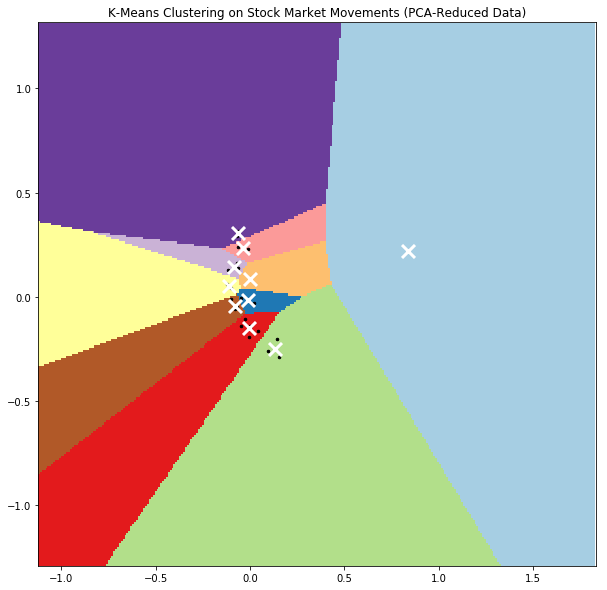

In [197]:
# Define step size of mesh
h = 0.01

# plot the decision boundary
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:,0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain abels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# define colorplot
cmap = plt.cm.Paired

# plot figure
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(Z, interpolation='nearest',
 extent = (xx.min(), xx.max(), yy.min(), yy.max()),
 cmap = cmap,
 aspect = 'auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)


# plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
 marker='x', s=169, linewidth=3,
 color='w', zorder=10)

plt.title('K-Means Clustering on Stock Market Movements (PCA-Reduced Data)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()